# Model identification via MaxEnt

Here we perform many local optimizations with starting points on a grid over the relevant parameter space in order to identify a good candidate for a maximum entropy model.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy.optimize import minimize, OptimizeResult
from tqdm import tqdm
import string
import dill

## Opmization functions in the background

In [4]:
# the constraint tolerance of whether a set of parameters is still to be accepted as a member of M
tolerance = 1e-05

In [5]:
def keep_constr(x: np.ndarray) -> float:
    """Ensure that constraints are kept."
    
    Params:
        x: parameter set: x = [B_12, B_21, z_1, z_2]
        
    Returns:
        distance (in l_1-norm) from M
    """
    xi_1 = 3
    xi_2 = 5
    xi_3 = 4

    B_12 = x[0]
    B_21 = x[1]
    z_1 = x[2]
    z_2 = x[3]

    constr_1 = abs(xi_1 - (B_12 + z_2))
    constr_2 = abs(xi_2 - (B_21 + z_1 + B_12 + z_2))
    constr_3 = abs(xi_3 - (z_1 * B_12 + z_1 * z_2 + B_21 * z_2))

    res = constr_1 + constr_2 + constr_3
#    print("constr", res)
    return res

In [6]:
def theta_ET_func_np(u: np.ndarray, B: np.ndarray) -> tuple[float, float]:
    """Entropy rate per unit time and mean transit time.

    Using this customized function for the sake of speed and stability.
    Speed is important for being able to run many optimizations across all
    the relevant parameter space.
    
    Params:
        u: input vector
        B: compartmental matrix
        
    Returns:
        (theta, ET): entropy rate, mean transit time
    """
    B_11, B_12, B_21, B_22 = B[0, 0], B[0, 1], B[1, 0], B[1, 1]
    z_1 = -B_11 - B_21
    z_2 = -B_22 - B_12

    # steady state
    xss = -np.linalg.inv(B) @ u

    # mean transit time
    ET = xss.sum() / u.sum()

    def xminuslogx(x):
        """Make sure ``0*(1-log(0)) == 0``."""
        if x == 0:
            return 0
        return x * (1 - np.log(x))

    # "manual" computation of the entropy rate of the system with u and B
    H0 = xss[0] * (xminuslogx(B[1, 0]) + xminuslogx(z_1))
    H1 = xss[1] * (xminuslogx(B[0, 1]) + xminuslogx(z_2))
    theta = (H0 + H1) / ET
    
    return theta[0], ET

In [7]:
def f(x: np.ndarray, d: dict) -> float:
    """Target function to minimize: negative entropy rate per unit time.
    
    Args:
        x: parameter set: x = [B_12, B_21, z_1, z_2]
        d: dictionary to record optimization process
        
    Returns:
         -theta: negative entropy rate, to be minimized
    """
    B_12 = x[0]
    B_21 = x[1]
    z_1 = x[2]
    z_2 = x[3]

    B_11 = -(B_21 + z_1)
    B_22 = -(B_12 + z_2)

    B = np.array([[B_11, B_12], [B_21, B_22]])
    u = np.array([[1], [0]])

    # negative entropy rate, mean transit time
    theta, ET = theta_ET_func_np(u, B)
    
    # add values to history only if constraints are not too
    # severely broken, use globally set tolerance
    constr = keep_constr(x)
    if constr <= tolerance:
        # here we record the optimization process
        # not all of the values are later on used, but who knows what the future brings?
        d["entropy_values"].append(theta)
        d["constr_values"].append(constr)
        d["ET_values"].append(ET)
        d["admissible_points"].append([B_12, B_21, z_1, z_2])
        
    return -theta

## Show the tilde M system

1 1


0

In [43]:
# the tilde M system
B_11_tilde = -2
B_12_tilde = 2
B_21_tilde = 1
B_22_tilde = -3

B_tilde = np.array([[B_11_tilde, B_12_tilde], [B_21_tilde, B_22_tilde]])
u_tilde = np.array([[1], [0]])

xss_tilde = -np.linalg.inv(B_tilde) @ u_tilde

theta_tilde, ET_tilde = theta_ET_func_np(u_tilde, B_tilde)

print("tilde B =", B_tilde)
print("tilde xss =", xss_tilde)
print("tilde ET =", ET_tilde)
print("tilde entropy rate, theta=", round(theta_tilde, 3))
print("\n----------------------\n")

z_1_tilde = -(B_11_tilde + B_21_tilde)
z_2_tilde = -(B_22_tilde + B_12_tilde)
print("tilde z_1 =", z_1_tilde, "tilde z_2 =", z_2_tilde)
print("constraint:", keep_constr(np.array([B_12_tilde, B_21_tilde, z_1_tilde, z_2_tilde])))

tilde B = [[-2  2]
 [ 1 -3]]
tilde xss = [[0.75]
 [0.25]]
tilde ET = 1.0
tilde entropy rate, theta= 1.903

----------------------

tilde z_1 = 1 tilde z_2 = 1
constraint: 0


## Global MaxEnt search

We make a grid on the four-dimensional parameter space for B_12, B_21, z_1, z_2. The points on the grid are staarting points for a nonlinear optimization in order to maximize the entropy rate theta (precise: minimize -theta).

In [9]:
# parameter values: B_12, B_21, z_1, z_2

# min and max values for "relevant" parameter space
min_par, max_par = 0, 5

# grid coarsity for starting points of optimization
step = 0.2

# parameter space for one single parameter
single_par_space = np.arange(min_par, max_par+step, step)

# the cartesian product of the single parameter space gives us
# the four-dimensional parameter space to scan through
par_space = list(itertools.product(*([single_par_space] * 4)))

len(par_space)

456976

In [10]:
def optimization(x0: np.ndarray) -> tuple[OptimizeResult, dict]:
    """MaxEnt optimization for starting point x0.
    
    Params:
        x0: starting point parameter set, x = [B_12, B_21, z_1, z_2]
        
    Returns:
        min_res: result of the optimization
        d: dict with records of the optimization process
    """
    # boundaries for parameters during the optimization
    bnds = [(0, None)] * 4
    constr = {"type": "eq", "fun": keep_constr}

    # dictionary to record the optimization process
    d = {
        "entropy_values": [], # thetas
        "x_values": [], # final parameters found by optimization
        "constr_values": [], # distance of parameters from M (l_1-norm)
        "ET_values": [], # mean transit times
        "admissible_points": [] # parameters during optimization in M with pre-set tolerance
    }
    
    # run the optimization with x0 as starting point and record the process
    min_res = minimize(f, x0, bounds=bnds, constraints=constr, tol=1e-6, args=(d,))
    
    return min_res, d

In [11]:
# list of all successful optimizations on the "global" grid
results = []

# run the local optimizations on the "global" grid
for x0 in tqdm(par_space):
    try:
        min_res, d = optimization(x0)
        
        # ignore unsuccessful optimizations
        if min_res.success:
            results.append((-min_res.fun, x0, min_res.x, d))
    except np.linalg.LinAlgError:
        # B derived from x0 is not an invertible (compartmental) matrix
        # do not record because the parameters are not valid
        pass

100%|████████████████████████████████████| 456976/456976 [8:56:11<00:00, 14.20it/s]


In [12]:
# sort the results, first element is the one with the highest theta
# structure: (theta, x0, y, d)
# y is the parameter set found by the local optimization
results_sorted = sorted(results, key=lambda res: res[0], reverse=True)



In [13]:
# number of randomly selected optimization runs to show in the plots
N = 1000

# choose N random optimizations to show in the plots
# we need many grid points in order to ensure to find a good global max candidate
# showing all simulations would overload the plots, so we show some random selection
# and the found optimal simulation and the tilde system
indices = np.random.choice(list(np.arange(len(results_sorted))), size=np.minimum(N, len(results_sorted)), replace=False)
results_sorted_sampled = [results_sorted[0]] + [results_sorted[i] for i in indices]

len(results_sorted), len(results_sorted_sampled)

(274803, 1001)

In [14]:
filename = "model_id.dmp"

In [15]:
# save results to disk
with open(filename, "wb") as f:
    dill.dump(results_sorted_sampled, f)

In [16]:
# load results from disk
# allows to plot without doing the entire computation again
with open(filename, "rb") as f:
    results_sorted_sampled = dill.load(f)

In [33]:
# global maximum parameter set starting point
p0_max = results_sorted_sampled[0][1]

# global maximum parameter set found by local optimizations on the grid
p_max = results_sorted_sampled[0][2]

# global max entropy rate
theta_max = results_sorted_sampled[0][0]

print("best starting point for optimization, p0_max = (B_12, B_21, z_1, z_2) =", np.round(p0_max, 3))
print("end point of optimization with best starting point, p_max =", np.round(p_max, 3))
print("entropy rate at end point, theta_max =", round(theta_max, 3))

best starting point for optimization, p0_max = (B_12, B_21, z_1, z_2) = [2.8 3.4 1.2 2.8]
end point of optimization with best starting point, p_max = [1.821 1.098 0.902 1.179]
entropy rate at end point, theta_max = 1.916


In [37]:
print("B_11 =", round(-p_max[0] - p_max[2], 3))
print("B_22 =", round(-p_max[1] - p_max[3], 3))

B_11 = -2.723
B_22 = -2.277


In [18]:
# set plotting properties

mpl.rcParams['lines.linewidth'] = 2

SMALL_SIZE = 26
MEDIUM_SIZE = 30
#BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

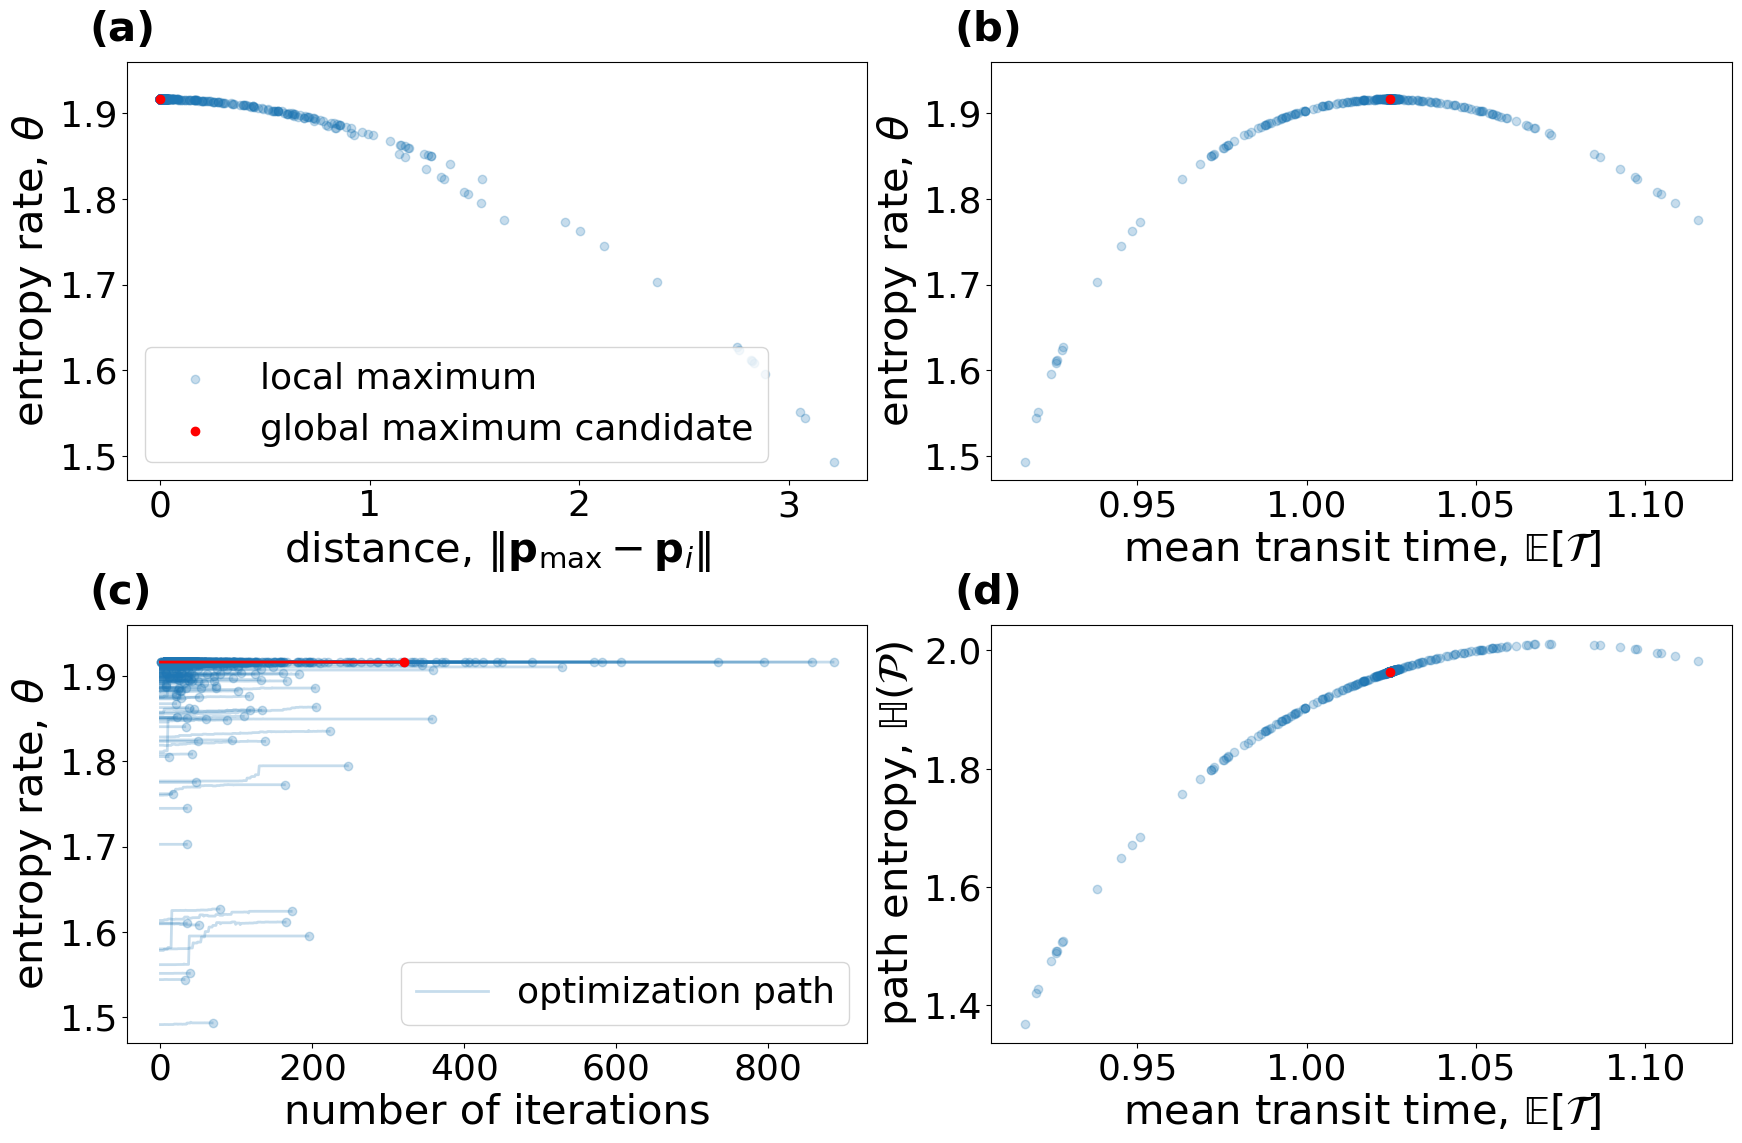

In [47]:
# make the plot

fig, axes = plt.subplots(figsize=(9*2, 6*2), ncols=2, nrows=2)
axes_list = axes.flatten()
panel_names = iter(string.ascii_lowercase[:len(axes_list)])

color = '#1f77b4'
alpha = 0.25

# distance in parameter space from optimal parameter set
p_max = np.array(results_sorted_sampled[0][2])
distances = np.array([np.linalg.norm(p_max-np.array(res[2]), ord=1) for res in results_sorted_sampled]).astype(float)
entropies = np.array([res[0] for res in results_sorted_sampled]).astype(float)
entropy_max = results_sorted[0][0]

ax = axes[0][0]                      
ax.scatter(distances, entropies, alpha=alpha, label="local maximum")
p_tilde = np.array([B_tilde[0, 1], B_tilde[1, 0], -B_tilde[0, 0]-B_tilde[1, 0], -B_tilde[1, 1]-B_tilde[0,1]]).astype(float)
#ax.scatter(np.linalg.norm(p_max-p_tilde), theta_tilde, c="red", marker="x", label=r"$\widetilde{M}$")
ax.scatter(0, entropy_max, c="red", label="global maximum candidate")
ax.set_xlabel(r"distance, $\|\mathbf{p}_{\mathrm{max}}-\mathbf{p}_i\|$")
ax.set_ylabel(r"entropy rate, $\theta$")
ax.set_ylim([ax.get_ylim()[0], 1.96])
ax.legend(loc=3)
                 
# theta vs mean transit time
ETs = np.array([res[3]["ET_values"][-1] for res in results_sorted_sampled]).astype(float)
ET_max = results_sorted[0][3]["ET_values"][-1]

ax = axes[0][1]
ax.scatter(ETs, entropies, alpha=alpha, label="local maximum")
ax.scatter(ET_max, entropy_max, c="red", label="global maximum candidate")
#ax.scatter(ET_tilde, theta_tilde, c="red", marker="x", label=r"$\widetilde{M}$")
ax.set_xlabel(r"mean transit time, $\mathrm{\mathbb{E}}[\mathcal{T}]$")
ax.set_ylabel(r"entropy rate, $\theta$")
ax.set_ylim([ax.get_ylim()[0], 1.96])
#ax.legend(loc=4)


# optimization paths
ax = axes[1][0]
for k, res in enumerate(results_sorted_sampled):
    entropy, x0, y, d = res
    if k == 0:
        ax.plot(d["entropy_values"], c=color, alpha=alpha, label="optimization path")
    else:
        ax.plot(d["entropy_values"], c=color, alpha=alpha)
    ax.scatter(len(d["entropy_values"]), d["entropy_values"][-1], c=color, alpha=alpha)

entropy, x0, y, d = results_sorted[0]
ax.plot(d["entropy_values"], c="red")
ax.scatter(len(d["entropy_values"]), d["entropy_values"][-1], c="red", zorder=2)
ax.set_xlabel("number of iterations")
ax.set_ylabel(r"entropy rate, $\theta$")
ax.set_ylim([ax.get_ylim()[0], 1.96])
ax.legend(loc=4)


# path entropy vs mean transit time
ax = axes[1][1]
ax.set_ylabel(r"path entropy, $\mathrm{\mathbb{H}}(\mathcal{P})$")
#ax.scatter(ETs*entropies, entropies, alpha=alpha)
ax.scatter(ETs, ETs*entropies, alpha=alpha)
#ax.scatter(ETs[0]*entropies[0], entropies[0], c="red")
#ax.scatter(ET_tilde*theta_tilde, theta_tilde, c="red", marker="x")
ax.scatter(ET_max, ET_max*entropy_max, c="red")
#ax.scatter(ET_tilde, ET_tilde*theta_tilde, c="red", marker="x")
#ax.set_ylim([ax.get_ylim()[0], 1.96])
ax.set_xlabel(r"mean transit time, $\mathrm{\mathbb{E}}[\mathcal{T}]$")


# add panel names
for ax, panel_name in zip(axes_list, panel_names):
    ax.text(-0.05, 1.05, f"({panel_name})", transform=ax.transAxes, size=MEDIUM_SIZE, weight='bold')


fig.tight_layout()
fig.tight_layout(w_pad=0.2, h_pad=0.0)

# save figures
fig.savefig("model_id.pdf")
fig.savefig("model_id.png")

plt.show()
